In [4]:
import os
import numpy as np
import pandas as pd
import shutil
from functools import partial
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import cv2

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, Input, Dropout, Conv2D, Permute
from tensorflow.keras import Model 
import albumentations as A

from transformers import TFViTModel

%matplotlib inline

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [9]:
# ALL_CLASSES = ['anger', 'contempt', 'disgust', 'fear', 
#            'happy', 'neutral', 'sad', 'surprised'] 
CLASSES = ['fear', 'happy', 'neutral', 'sad', 'surprised'] # delete contempt, disgust and anger
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8 * 2
LEARNING_RATE = 1e-3
EPOCHS = 60

In [5]:
NUM_CLASSES

5

## 1. Data preparation

In [6]:
path_dir = '/kaggle/input/facial-emotion-recognition/'
path_csv = os.path.join(path_dir, 'emotions.csv')

In [7]:
data = pd.read_csv(path_csv)
data

,set_id,gender,age,country
0,0,FEMALE,36,RU
1,1,FEMALE,37,RU
2,2,FEMALE,36,RU
3,3,MALE,29,RU
4,4,FEMALE,43,RU
5,5,MALE,49,RU
6,6,FEMALE,38,RU
7,7,MALE,19,PH
8,8,FEMALE,29,RU
9,9,FEMALE,32,RU


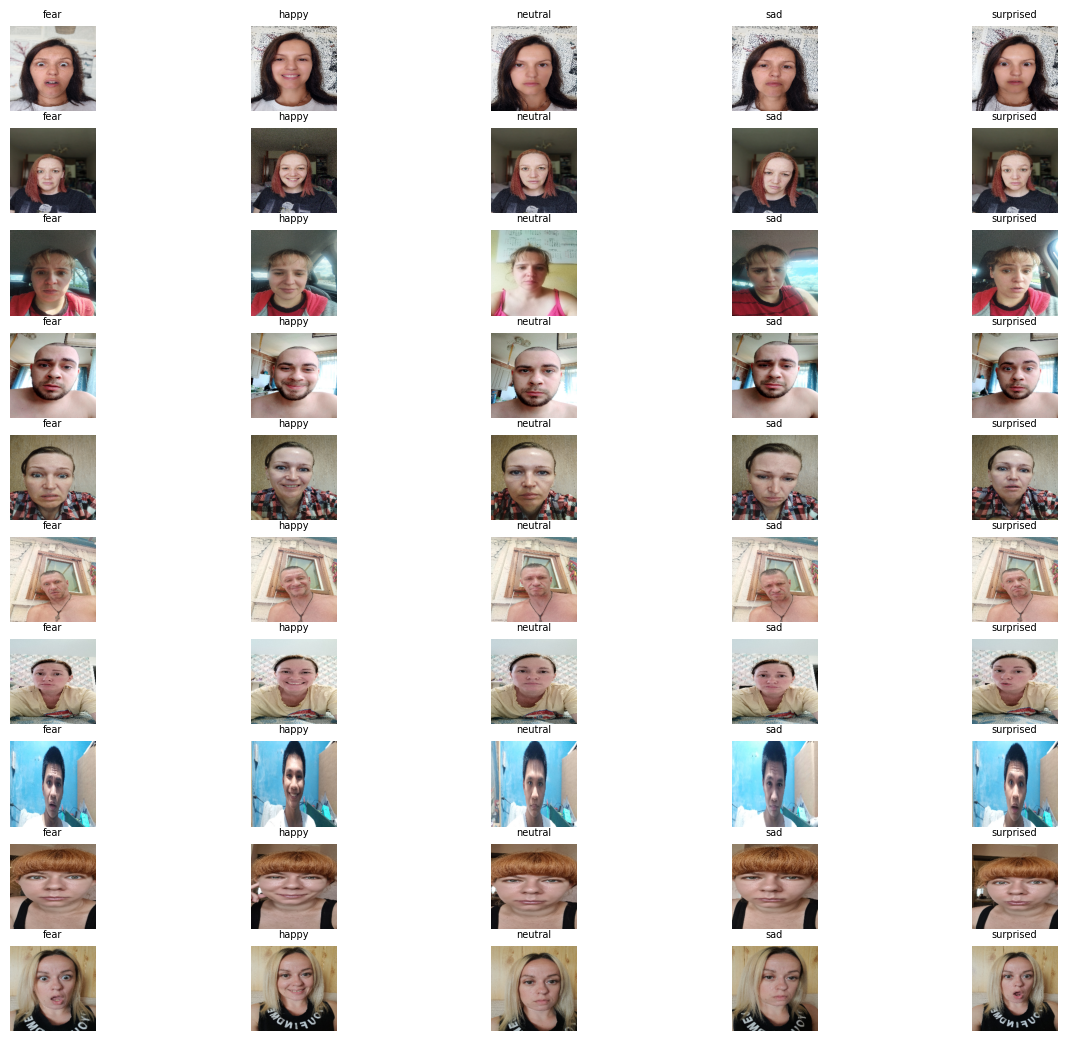

In [10]:
path_imgs = os.path.join(path_dir, 'images')
plt.figure(figsize=(15, 25))
IM_SIZE = (200, 200)
ind = 0
for set_id in data['set_id'][:10]:
    for class_name in CLASSES:
        ind += 1
        path_img = os.path.join(path_imgs, str(set_id), class_name.capitalize() + '.jpg')
        plt.subplot(len(data), len(CLASSES), ind)
        img = cv2.imread(path_img)
        img = cv2.resize(img, IM_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.title(class_name, fontsize=7)
        plt.imshow(img)
        plt.axis('off')

In [11]:
val_ind = [0, 2, 15, 16, 5] # four females and one male for validation
bad_ind = [11]
data_train = data[~data.index.isin(val_ind + bad_ind)].reset_index(drop=True)
data_val = data[data.index.isin(val_ind)].reset_index(drop=True)

In [12]:
def create_dirs(data, path, new_path):
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    for class_name in CLASSES:
        os.makedirs(os.path.join(new_path, class_name), exist_ok=True)
    for set_id in data['set_id']:
        for class_name in CLASSES:
            path_src = os.path.join(path, str(set_id), class_name.capitalize() + '.jpg')
            path_dist = os.path.join(new_path, class_name, f'{set_id}_{class_name}.jpg')
            shutil.copyfile(path_src, path_dist)

In [12]:
#shutil.rmtree(path_val)

In [13]:
path_train, path_val = 'input/train', 'input/val'
path_imgs = os.path.join(path_dir, 'images')
create_dirs(data_val, path_imgs, path_val)
create_dirs(data_train, path_imgs, path_train)

In [14]:
!ls $path_train

fear  happy  neutral  sad  surprised


In [15]:
dataset_train = tf.keras.utils.image_dataset_from_directory(
    directory=path_train,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    color_mode='rgb',
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=1,
    validation_split=None,
)

dataset_val = tf.keras.utils.image_dataset_from_directory(
    directory=path_val,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    color_mode='rgb',
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=1,
    validation_split=None,
)

Found 65 files belonging to 5 classes.
Found 25 files belonging to 5 classes.


In [16]:
@tf.function
def image_scale(image, label):
    image /= 255.
    return image, label

In [17]:
dataset_train = dataset_train.map(image_scale,
                                  num_parallel_calls=AUTOTUNE)
dataset_val = dataset_val.map(image_scale,
                                  num_parallel_calls=AUTOTUNE)

In [18]:
def view_image(ds, num_plt=2):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    print("shape of images:", image.shape)
    image = image.numpy()
    label = label.numpy()
    print("max, min values in image = ", image.max(), image.min())
    bs = image.shape[0]
    fig = plt.figure(figsize=(10, 5))
    for i in range(bs):
        ax = fig.add_subplot(num_plt, int(np.ceil(bs / num_plt)), i + 1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"{CLASSES[np.argmax(label[i])]}", fontsize=7)

shape of images: (16, 224, 224, 3)
max, min values in image =  1.0 0.0


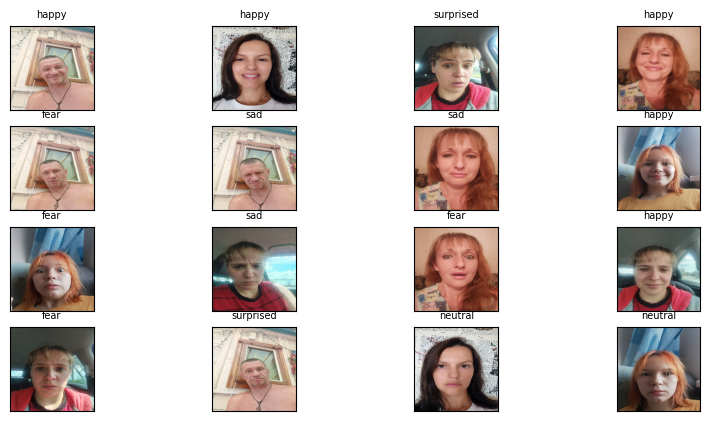

In [19]:
view_image(dataset_val.batch(16).prefetch(tf.data.AUTOTUNE), num_plt=4)

### Data Augmentation

In [20]:
transforms = A.Compose([
    A.CropAndPad(percent=0.17, p=0.2),
    A.HorizontalFlip(p=0.4),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.3),
    A.CoarseDropout(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.27, rotate_limit=10, p=0.3),
    A.OneOf([
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),    
])

In [21]:
def aug_fn(image):
    data = {'image': image}
    image = transforms(**data)['image']
    return image

input_prepoccess_f = lambda image, label: (2. * image - 1., label)

@tf.function
def image_preprocessing(image, label, scale=True):
    image = tf.numpy_function(func=aug_fn, inp=[image],
                              Tout=tf.float32)
    image.set_shape((*IMAGE_SIZE, 3))
    image = tf.clip_by_value(image, clip_value_min=0., 
                               clip_value_max=1.)
    # mobilenet_v2 preprocess of input
    if scale:
        image = 2. * image - 1.
    return image, label

In [22]:
dataset_train_ = dataset_train.map(partial(image_preprocessing, scale=False), num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = 8,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

shape of images: (16, 224, 224, 3)
max, min values in image =  1.0 0.0


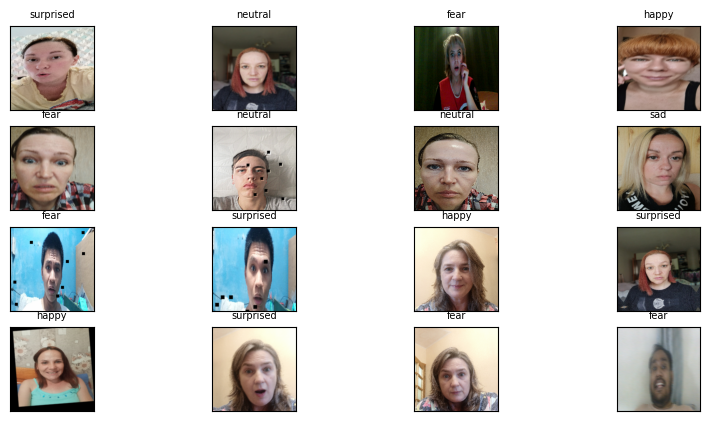

In [23]:
view_image(dataset_train_, num_plt=4) # visualize augmented data

In [24]:
buffer_size = len(data)
dataset_train_m = dataset_train.map(image_preprocessing, num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_val_m = dataset_val.map(input_prepoccess_f, num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 2. Model training

### EfficientNet

In [26]:
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
backbone = keras.applications.efficientnet_v2.EfficientNetV2B3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    pooling=None,
    include_preprocessing=False,
)
backbone.trainable = False
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_cls = Model(inputs, outputs, name='facial_exp_cls_efficientnet') # 41 - 50 6 classes B2 32, 0.001, 128
model_cls.summary()

Model: "facial_exp_cls_efficientnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, 7, 7, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                       

In [27]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
model_cls.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

In [28]:
history = model_cls.fit(dataset_train_m, epochs=EPOCHS, 
          validation_data=dataset_val_m, verbose=1, callbacks=[reduce_lr, early_stop])

Epoch 1/60
5/5 [==============================] - 25s 2s/step - loss: 2.3008 - categorical_accuracy: 0.2308 - top_k_categorical_accuracy: 0.3538 - val_loss: 1.7028 - val_categorical_accuracy: 0.1600 - val_top_k_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 2/60
5/5 [==============================] - 9s 1s/step - loss: 2.3641 - categorical_accuracy: 0.0769 - top_k_categorical_accuracy: 0.3385 - val_loss: 1.6954 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 3/60
5/5 [==============================] - 8s 1s/step - loss: 1.9278 - categorical_accuracy: 0.1692 - top_k_categorical_accuracy: 0.3692 - val_loss: 1.6833 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 4/60
5/5 [==============================] - 8s 1s/step - loss: 2.0180 - categorical_accuracy: 0.2000 - top_k_categorical_accuracy: 0.4154 - val_loss: 1.6754 - val_categorical_accuracy: 0.2000 - val_top_k_categorical_accuracy: 0.5200 - lr

### ViT

In [36]:
buffer_size = len(data)
dataset_train_t = dataset_train.map(partial(image_preprocessing, scale=False), num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_val_t = dataset_val.shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [37]:
model_name = 'google/vit-base-patch16-224-in21k'
base_model = TFViTModel.from_pretrained(model_name)
inputs = Input(shape=(224, 224, 3))
x = Permute((3, 1, 2))(inputs)
base_model.trainable = False
x = base_model.vit(x)[0]
x = keras.layers.GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01))(x) # batchnorm
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
hf_model = Model(inputs=inputs, outputs=outputs, name='ViT_cls')

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [38]:
hf_model.summary()

Model: "ViT_cls"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 permute (Permute)           (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 global_average_pooling1d (G  (None, 768)              0   

In [39]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
hf_model.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
)

In [40]:
history = hf_model.fit(dataset_train_t, epochs=EPOCHS, 
          validation_data=dataset_val_t, verbose=1, callbacks=[reduce_lr, early_stop])

Epoch 1/60
5/5 [==============================] - 57s 8s/step - loss: 4.4100 - categorical_accuracy: 0.1692 - top_k_categorical_accuracy: 0.3231 - val_loss: 3.7760 - val_categorical_accuracy: 0.2800 - val_top_k_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 2/60
5/5 [==============================] - 36s 7s/step - loss: 4.0020 - categorical_accuracy: 0.2615 - top_k_categorical_accuracy: 0.4615 - val_loss: 3.7405 - val_categorical_accuracy: 0.2800 - val_top_k_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 3/60
5/5 [==============================] - 46s 10s/step - loss: 3.8060 - categorical_accuracy: 0.4154 - top_k_categorical_accuracy: 0.5692 - val_loss: 3.7041 - val_categorical_accuracy: 0.3200 - val_top_k_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 4/60
5/5 [==============================] - 36s 7s/step - loss: 3.7717 - categorical_accuracy: 0.3231 - top_k_categorical_accuracy: 0.6308 - val_loss: 3.6672 - val_categorical_accuracy: 0.2800 - val_top_k_categorical_accuracy: 0.6000 

## 3. ViT model evaluation

In [43]:
input_prepoccess_f = lambda image, label: (2. * image - 1., label)
dataset_t_ = tf.keras.utils.image_dataset_from_directory(
    directory=path_val,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    color_mode='rgb',
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=False,
    validation_split=None,
).map(image_scale, num_parallel_calls=AUTOTUNE)
dataset_t_t = dataset_t_.batch(1)

Found 25 files belonging to 5 classes.


In [44]:
pred = hf_model.predict(dataset_t_t)

25/25 [==============================] - 15s 455ms/step


In [45]:
def view_image_pred(ds, pred, num_plt=4):   
    bs = pred.shape[0]
    fig = plt.figure(figsize=(10, 15))
    for i, (image, label) in enumerate(ds.as_numpy_iterator()):
        ax = fig.add_subplot(num_plt, bs // num_plt, i + 1, xticks=[], yticks=[])
        ax.imshow((image[0] + 1.) * 0.5)
        ax.set_title(f"t={CLASSES[np.argmax(label)]}, p={np.array(CLASSES)[np.argsort(pred[i])[-2:][::-1]]}", fontsize=7)

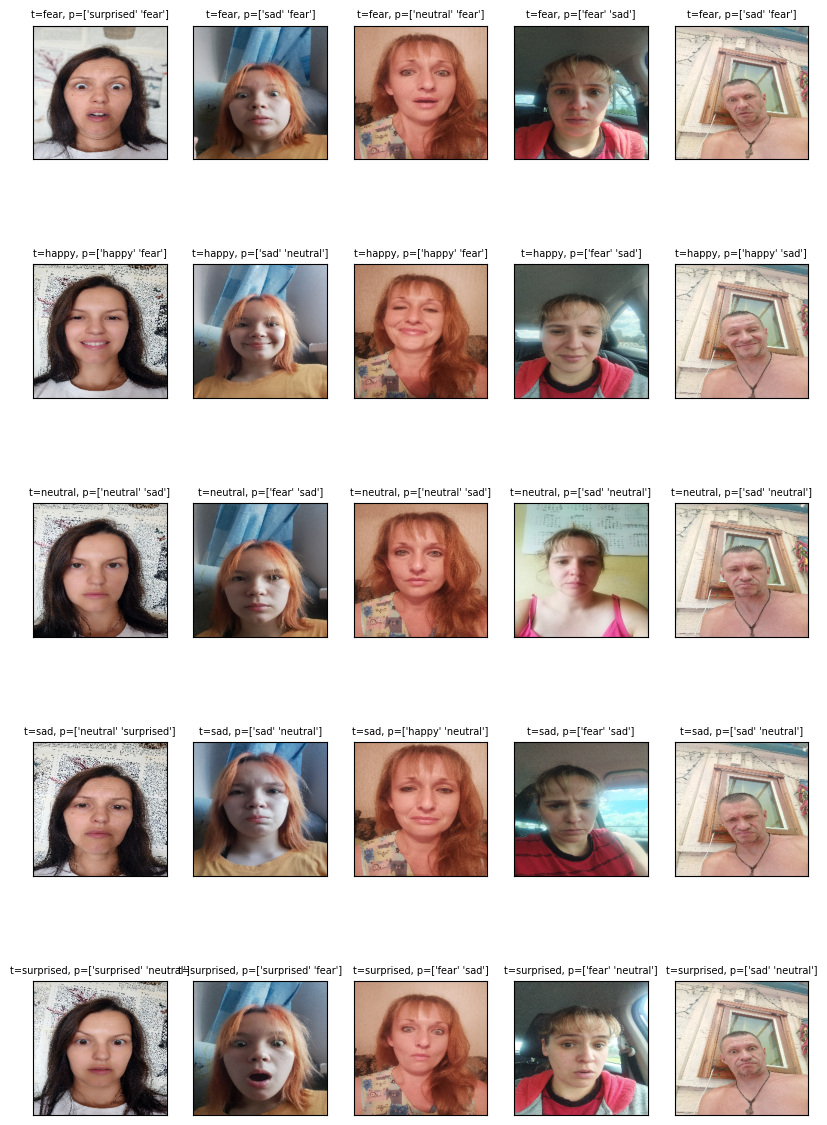

In [47]:
view_image_pred(dataset_t, pred, num_plt=5) # true (t) label and predicted (p) with two highest probability

In [48]:
y_true = np.stack([label[0] for _, label in dataset_t.as_numpy_iterator()])
y_true = np.argmax(y_true, axis=-1)
y_pred = np.argmax(pred, axis=-1)
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=2))

              precision    recall  f1-score   support

        fear       0.17      0.20      0.18         5
       happy       0.75      0.60      0.67         5
     neutral       0.50      0.40      0.44         5
         sad       0.25      0.40      0.31         5
   surprised       0.67      0.40      0.50         5

    accuracy                           0.40        25
   macro avg       0.47      0.40      0.42        25
weighted avg       0.47      0.40      0.42        25



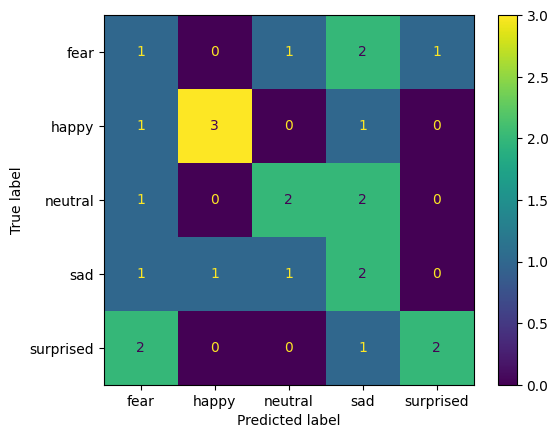

In [49]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=CLASSES)
disp.plot()
plt.show()